In [2]:
import numpy as np
from scipy.optimize import least_squares

from matplotlib import pyplot as plt
import pandas as pd

from marketdata import MarketData
from heston import HestonModel
from blackscholes import bs_call, __implied_volatility
from heston_calibration import *

import matplotlib.pyplot as plt


from ipywidgets import interact, FloatSlider


**Introduction**

This notebook concerns the calibration of the heston model and proposes a modification of ridge regression in MSE via the fisher information metric. The main issue at hand is "flatness" near local optima, where we may converge to unreasonable parameters. Rather than setting ad hoc priors and adjusting a ridge coefficient until we get a sensible answer, we consider a penalization based on Fisher information.





**A brief recollection of the Heston model**

The Heston model is based on the same no-arbitrage principles as Black-Scholes, regards volatility as a stochastic process with mean reversion.

This fits into the usual Brownian motion framework

$$dS_t=\mu S_t dt+\sqrt{\nu}_t S_t dW_t^{S}$$

$$d\nu_t=\kappa(\theta-\nu_t)dt+\xi\sqrt{\nu_t}dW_t^{\nu}.$$

where $W_t^S,W_t^{\nu}$ 
are continuous random walks with correlation 
$\rho$. 
We can solve these equations simultaneously 
in the risk-neutral model under some assumptions such 
as constant correlation (covariance), 
constant "volatility of volatility" or 
randomness i.e. second variation, and 
constant rate of reversion, an expected variance. 
In practice, this is subject to boundary conditions.

$\nu_0$ is the initial variance

$\theta $ is the long variance (expected value of volatility as $t \to \infty$)

$\rho $ is the correlation

$\kappa $ is the rate of reversion

$\xi $ is the volatility of volatility .


this model was prefered to a linear differential equation for the volatility (Ornstein-Uhlenbeck) because the volatility is never negative. In particular, the solution for the Heston model is strictly positive subject to the relation that 
$$2\kappa \theta>\xi^2 $$



**Computational Aspects**

In the pricing of a European call option, one derives from put-call parity the familiar formula



$$C(\theta,K,T)= e^{-rT}\mathbb E[(S_T-K)\cdot \mathbb 1_{S_T \geq K}(S_T)],$$

where $\theta=[v_0,\overline{v},\rho,\kappa,\sigma]^T$. Using the linearity of expectation, one can re-express this as

$$ C(\theta,K,T)=S_0P_1-e^{rT}KP_2,$$

where $P_2$ is the probability of $S_T$ finishing in the money, and $P_1$ is a random variable weighted by this probability (it is the probability with respect to the numeraire given by $S_T$ rather than cash.)

By using a Fourier transform, [Heston](https://www.ma.imperial.ac.uk/~ajacquie/IC_Num_Methods/IC_Num_Methods_Docs/Literature/Heston.pdf) derived closed form solutions for $P_1$ and $P_2$ in terms of the characteristic function $\phi(\theta,u,T)$:
$$
\begin{align*}
P_1&=\frac{1}{2}+\frac{1}{\pi}\int_{0}^\infty \mathrm{Re}\left(\frac{e^{-iu \mathrm{log} K}}{uiF} \phi(\theta,u-i,T) \right)du \\
P_2&=\frac{1}{2}+\frac{1}{\pi}\int_{0}^\infty \mathrm{Re}\left(\frac{e^{-iu \mathrm{log} K}}{uiF} \phi(\theta,u,T) \right) du
\end{align*}
$$
where $F:=S_0e^{rT}$ is the forward price of the underlying stock $S_0$. There were previously several issues  with calibrating the parameter vector $\theta$,
due to taking consistent branches of the complex logarithm in the expression for $\phi$. 

However, [Cui-Rollin-Germano](https://arxiv.org/abs/1511.08718) provided 
a new expression for $\phi$ that was analytically tractable enough to compute the gradient of $\phi$ with respect to each parameter, and thus efficiently compute the gradient
for $C$ efficiently via least squares. That is, we calibrate the model, by taking market data $C^{*}(K_i,T_i)$ for a call option with strike $K_i$ and maturity $T_i$, and minimizing

$$
\begin{align*}
    \mathrm{min}_{\theta \in \mathbb R^m}\frac{1}{2}r^T(\theta)r\theta,
\end{align*}
$$
where $r_i(\theta):=C(\theta,K_i,T_i)-C^{*}(K_i,T_i)$ are residual vectors. In this case, we have that

$$
\begin{align*} 
    \nabla f&= Jr\\
    \nabla \nabla^T f&=JJ^T+\sum_{i=1}^n r_iH(r_i)
\end{align*}
$$

so we can employ a root finding algorithm to minimize our objective function, so long as we have an expression for the gradient.

we provide all the relevant formulas in the ```HestonModel``` class, notably the method ```_gradient```, which features vectorized numerical integration via ```Scipy.quad_vec```.


**Calibrating Initial Volatility**

We can improve our initial guess quickly in several ways. The most obvious is setting the initial volatility $v_0$ in a more intelligent manner.

There are a few ways to do this, but we follow the observations made by Gatheral in 
["The Volatility Surface." (pg 34-35)](http://www.hk.free.fr/Docs/The%20Volatility%20Surface%20-%20A%20Practitioner's%20Guide%20%5BJim%20Gatheral%5D.pdf)


First, here are some helpful heuristics: $v_0$ controls  the position of volatility smile, $\rho$ controls the skewness, 
$\kappa$ and $\xi$ the convexity, while $\kappa(\theta-v_0)$ controls the term structure for implied volatility.
For ATM options with short maturity $T \to 0$, the implied volatility $\sigma_{BS}$ approximates to $\sqrt{v_0}$ 
(there's no room to smile and the stochastic part in the Heston Model is not so relevant.)

For sufficiently short $T$, the option price behaves like:
$$
\begin{align*}
C(S_0, K, T) \simeq C_{BS}(S_0, K, T; \sigma = \sqrt{v_0})
\end{align*}
$$
where $C_{BS}$ is the Black-Scholes price with constant volatility $\sqrt{v_0}$.

For small $T$, we can approximate:
$$
\begin{align*}
\int_0^T v_s ds \approx v_0 T + O(T^{3/2})
\end{align*}
$$

meaning that the total variance $[0,T]$ is approximately $v_0$, making the option price:
$$
\begin{align*}
C \approx C_{BS}(S_0, K, T; \sqrt{v_0})
\end{align*}
$$

This leads us to  initialize $v_0$ at the Black-Scholes implied volatility. We implement this in the ```MarketData``` class via two functions that filter to short term and atm options.

For implied volatility, we use two methods ```__jackel_initial_guess``` which is a simplification for initializing options pricing by [Peter Jackel](http://www.jaeckel.org/ImpliedNormalVolatility.pdf).
Here, we distinguish between options ATM, deep ITM, and then all others which are based on heuristics. For at the money, we leave the heuristic solution

$$
\begin{align*}
    \sigma_{BS} \cong \sqrt{\frac{2\pi}{T}} \cdot \frac{c}{F}
\end{align*}
$$
where $T$ is time to maturity and $c$,$F$ are the forward prices of the observed market price $C^*$ and spot price $S_0$, respectively.

For deep in the money, we just guess $.4$, and otherwise, follow his algorithm.

For ```__implied_volatility``` we use a vectorized Newton's Algorithm on a Black-Scholes call price (otherwise one can use ```Scipy``` methods, but are forced to loop through the market data.)

Finally, we estimate $v_0$ by first filtering near at the money stock data via two methods ```short_term``` and ```atm```. All of this is packaged together in the
method ```initialize_volatility``` for a ```MarketData``` object.

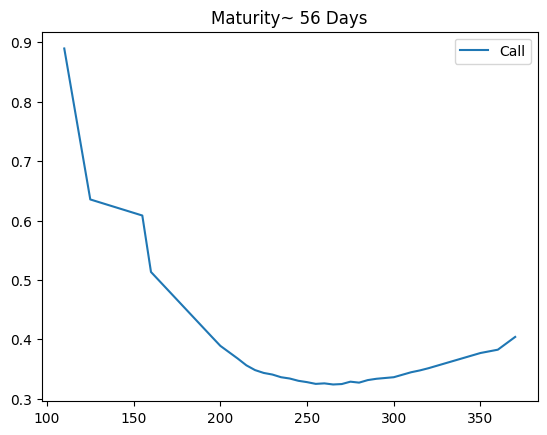

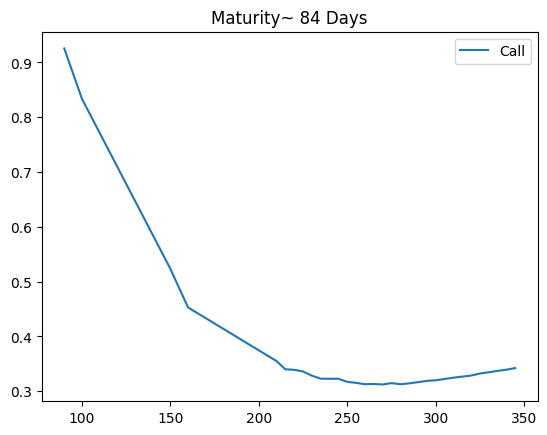

In [3]:
"""example MarketData usage to graph some volatility smiles"""


amazon_data:MarketData = MarketData.from_yahoo_finance("AMZN")
unique_maturities = np.unique(amazon_data.maturities)
short_mask = (unique_maturities < 0.3) & (unique_maturities > 0.1)
some_maturities = unique_maturities[short_mask]
for date in some_maturities:
    date_mask = amazon_data.maturities == date
    market_prices = amazon_data.market_prices[date_mask]
    strikes = amazon_data.strikes[date_mask]

    volatilities = (amazon_data.implied_volatility())[date_mask]

    plt.plot(strikes, volatilities, label="Call")

    plt.title(f"Maturity~ {int(date * 365)} Days")
    plt.legend()
    plt.show()

In [4]:
'''Loading Data'''
tickers = ["MSFT", "AMZN", "GOOGL", "SPY", "AAPL", "TSLA"]
market_data: dict[str, MarketData] = {}

for ticker in tickers:
    market_data[ticker] = MarketData.from_yahoo_finance(ticker)

We Clean data by removing severe outliers, and options very close to zero in value (less than a cent.) We validate data using

1. Monotonicity of strikes

2. Reasonable Implied Volatility (within 3x Black-Scholes IV for short term at the money options.)

3. Using  the no-arbitrage lower bound $$C \geq \mathrm{max}(S_0 - K*e^{rT}, 0).$$

In [5]:
sensible_data={}
insensible_data={}
for ticker in tickers:
    print(f"{ticker}")
    sensible_data[ticker],insensible_data[ticker]=MarketData.validate_option_data(market_data[ticker],check_iv=True,check_monotonicity=True,return_outliers=True)


MSFT
Removed 81 / 358 options (22.6%)
  - Lower bound violations: 15
  - Upper bound violations: 0
  - Monotonicity violations: 4
  - IV outliers/unsolvable: 62
AMZN
Removed 47 / 347 options (13.5%)
  - Lower bound violations: 2
  - Upper bound violations: 0
  - Monotonicity violations: 0
  - IV outliers/unsolvable: 45
GOOGL
Removed 104 / 420 options (24.8%)
  - Lower bound violations: 37
  - Upper bound violations: 0
  - Monotonicity violations: 5
  - IV outliers/unsolvable: 62
SPY
Removed 240 / 868 options (27.6%)
  - Lower bound violations: 78
  - Upper bound violations: 0
  - Monotonicity violations: 3
  - IV outliers/unsolvable: 159
AAPL
Removed 114 / 436 options (26.1%)
  - Lower bound violations: 22
  - Upper bound violations: 0
  - Monotonicity violations: 1
  - IV outliers/unsolvable: 91
TSLA
Removed 133 / 802 options (16.6%)
  - Lower bound violations: 65
  - Upper bound violations: 0
  - Monotonicity violations: 10
  - IV outliers/unsolvable: 58


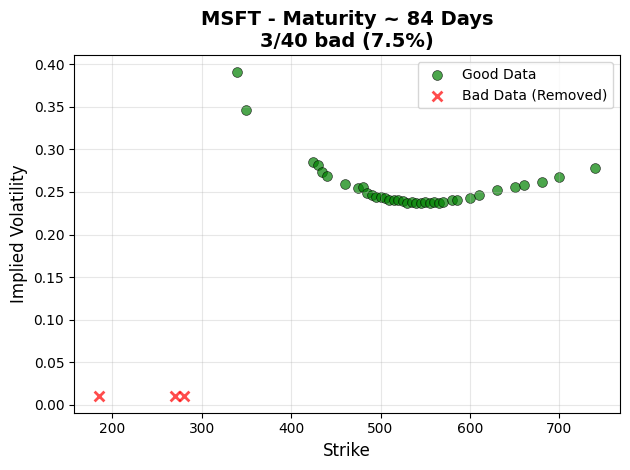

AMZN: No maturities with >5% bad data in the 0.1-0.3 year range


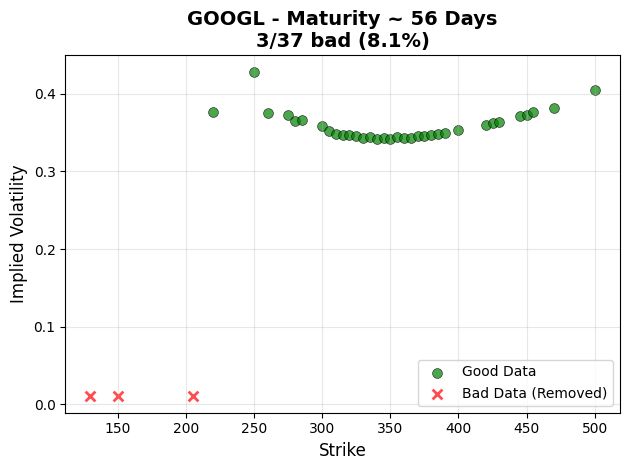

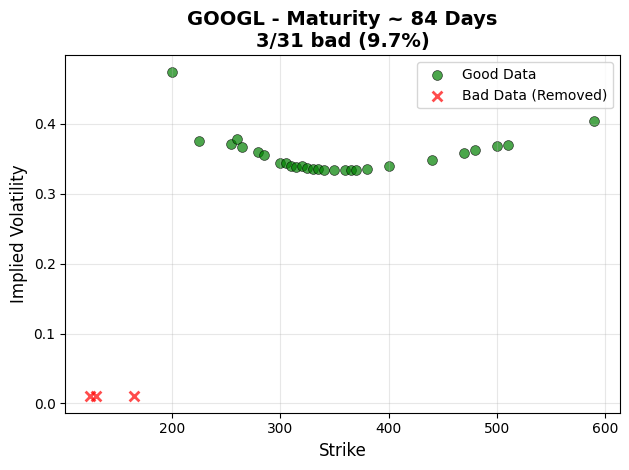

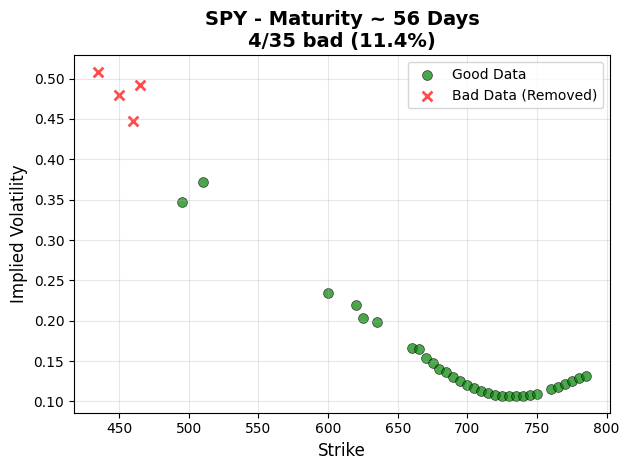

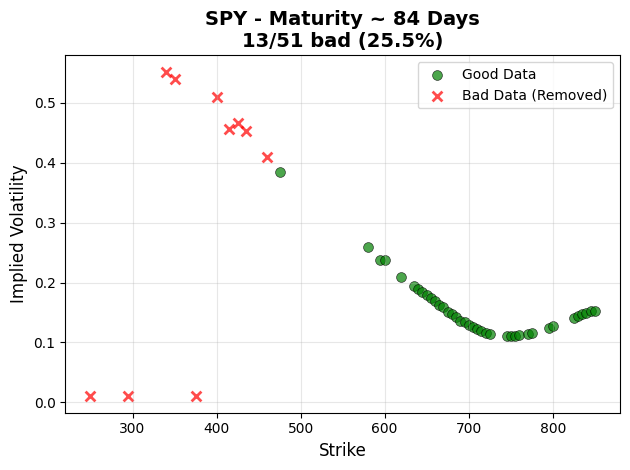

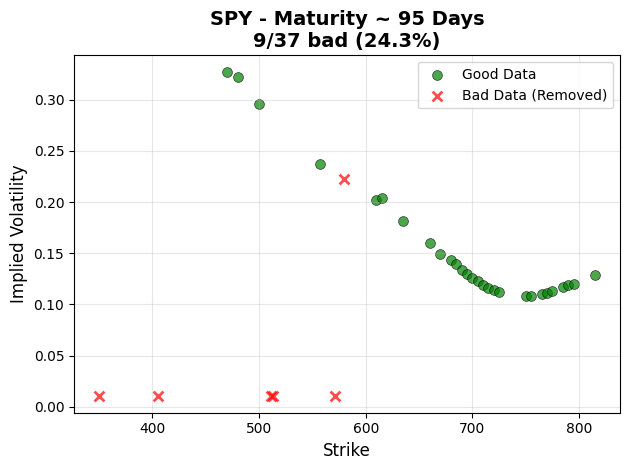

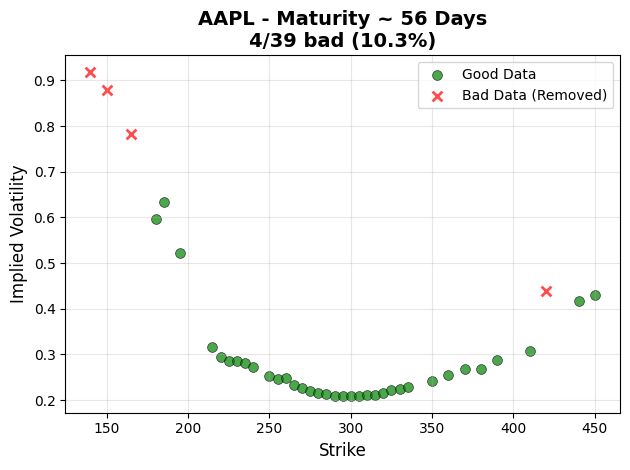

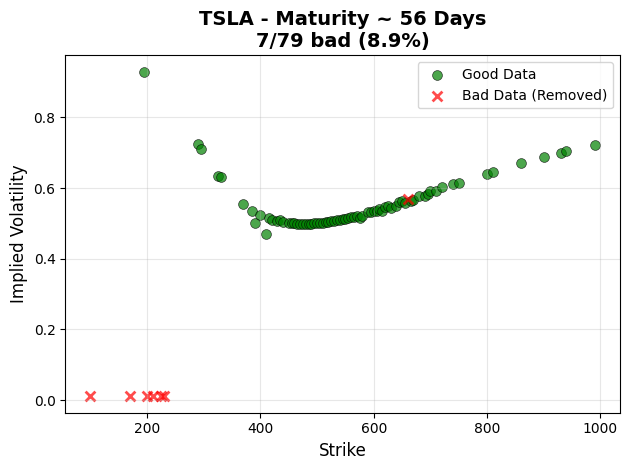

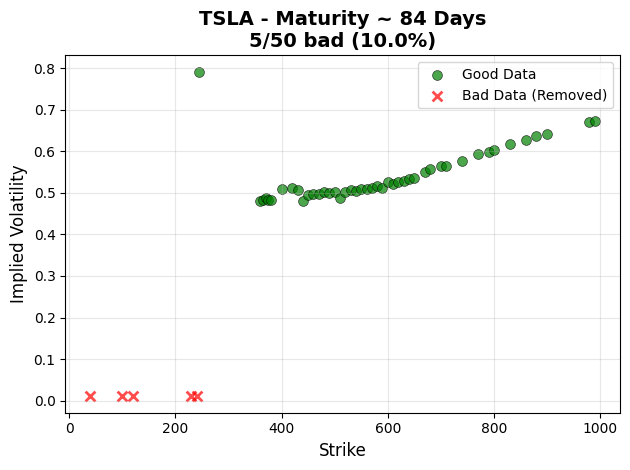

In [7]:
for ticker in tickers:
    ticker_data = market_data[ticker]
    good_data = sensible_data[ticker]
    bad_data = insensible_data[ticker]
    
    unique_maturities = np.unique(ticker_data.maturities)
    short_mask = (unique_maturities < 0.3) & (unique_maturities > 0.1)
    candidate_maturities = unique_maturities[short_mask]
    
    # Filter to only maturities where >5% of data was bad
    some_maturities = []
    for date in candidate_maturities:
        # Count total options for this maturity (good + bad)
        n_good = np.sum(good_data.maturities == date)
        n_bad = np.sum(bad_data.maturities == date)
        n_total = n_good + n_bad
        
        if n_total > 0:
            pct_bad = n_bad / n_total
            if pct_bad > 0.05:  # More than 5% bad
                some_maturities.append(date)
    
    if len(some_maturities) == 0:
        print(f"{ticker}: No maturities with >5% bad data in the 0.1-0.3 year range")
        continue
    
    for date in some_maturities:
        # All data (cleaned)
        date_mask_all = ticker_data.maturities == date
        strikes_all = ticker_data.strikes[date_mask_all]
        ivs_all = (ticker_data.implied_volatility())[date_mask_all]
        
        # Good data
        date_mask_good = good_data.maturities == date
        if np.any(date_mask_good):
            strikes_good = good_data.strikes[date_mask_good]
            ivs_good = (good_data.implied_volatility())[date_mask_good]
            plt.scatter(strikes_good, ivs_good, c='green', label='Good Data', 
                       s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
        
        # Bad data
        date_mask_bad = bad_data.maturities == date
        if np.any(date_mask_bad):
            strikes_bad = bad_data.strikes[date_mask_bad]
            ivs_bad = (bad_data.implied_volatility())[date_mask_bad]
            plt.scatter(strikes_bad, ivs_bad, c='red', label='Bad Data (Removed)', 
                       s=50, alpha=0.7, marker='x', linewidth=2)
        
        # Calculate stats for title
        n_good = np.sum(date_mask_good)
        n_bad = np.sum(date_mask_bad)
        pct_bad = 100 * n_bad / (n_good + n_bad)
        
        plt.xlabel('Strike', fontsize=12)
        plt.ylabel('Implied Volatility', fontsize=12)
        plt.title(f"{ticker} - Maturity ~ {int(date * 365)} Days\n{n_bad}/{n_good+n_bad} bad ({pct_bad:.1f}%)", 
                 fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

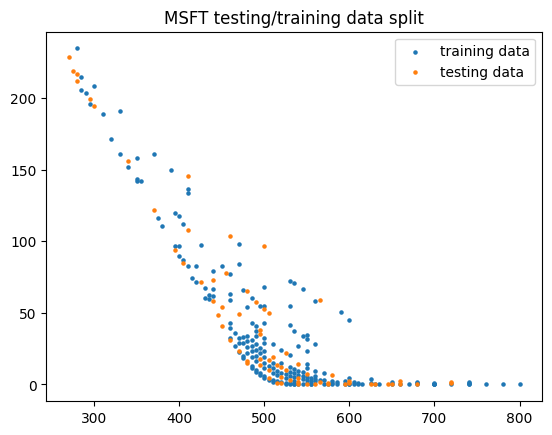

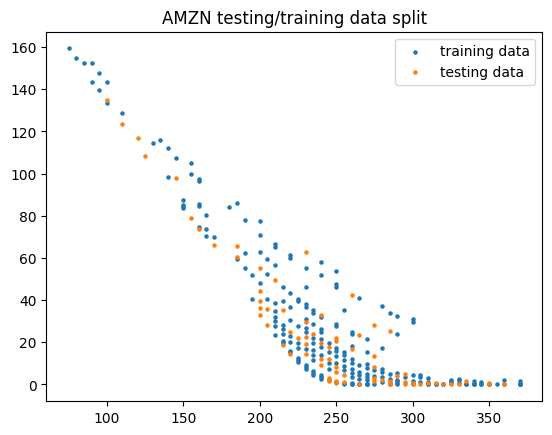

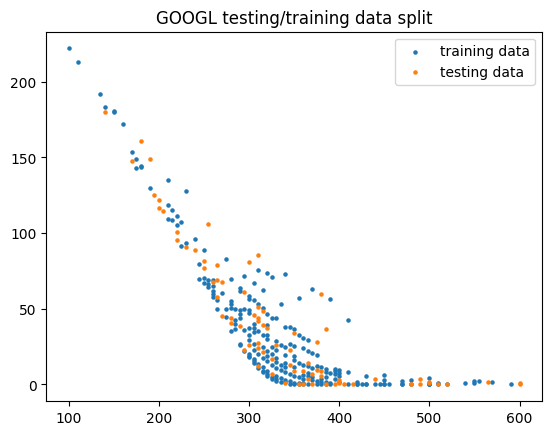

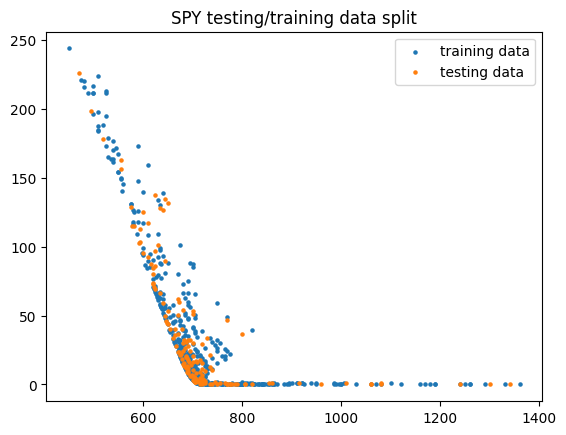

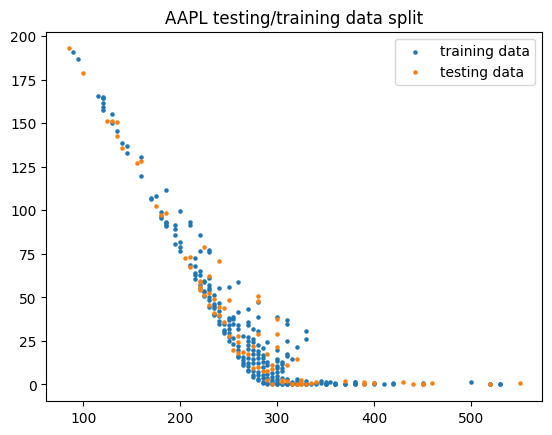

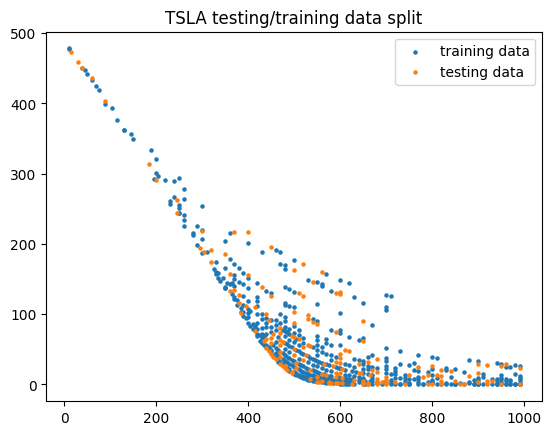

In [8]:
'''Split into testing and training data'''

training_data = {}
testing_data = {}
for ticker in tickers:
    training_data[ticker], testing_data[ticker] = sensible_data[
        ticker
    ].testing()
    ticker_testing = testing_data[ticker]

    plt.scatter(
        training_data[ticker].strikes,
        training_data[ticker].market_prices,
        label="training data",
        s=5,
    )
    plt.scatter(
        testing_data[ticker].strikes,
        testing_data[ticker].market_prices,
        label="testing data",
        s=5,
    )

    plt.legend()
    plt.title(f"{ticker} testing/training data split")
    plt.show()


In [10]:
'''We can now compare regularization methods for Heston Model calibration!'''

configs_to_test = {
        'No Reg': RegularizationConfig(regularization_type='none'),
        'Ridge': RegularizationConfig(
            regularization_type='ridge',
            ridge_weight=1,
            feller_weight=100.0
        ),
        'Fisher': RegularizationConfig(
            regularization_type='fisher',
            fisher_weight=1,
            feller_weight=50.0
        ),
        'Combined': RegularizationConfig(
            regularization_type='combined',
            ridge_weight=0.005,
            fisher_weight=0.02,
            feller_weight=75.0
        ),
    }
    
    # Store calibrated models
calibrated_models = {ticker: {} for ticker in training_data.keys()}

for ticker in training_data.keys():
    print(f"\n{'='*60}")
    print(f"Calibrating {ticker}")
    print(f"{'='*60}")
    
    calibrator = HestonCalibrator(training_data[ticker])
    
    for config_name, config in configs_to_test.items():
        print(f"\n{config_name}:")
        print("-" * 40)
        
        try:
            model = calibrator.calibrate(
                reg_config=config,
                verbose=1
            )
            calibrated_models[ticker][config_name] = model
            
        except Exception as e:
            print(f"  Calibration failed: {e}")
            continue
    
    # Compare results across tickers
    print("\n" + "="*60)
    print("COMPARISON ACROSS TICKERS")
    print("="*60)
    
    param_names = ['v0', 'v̄', 'ρ', 'κ', 'σ']
    
    for config_name in configs_to_test.keys():
        print(f"\n{config_name} - Parameters by Ticker:")
        print("-" * 80)
        
        # Header
        print(f"{'Ticker':<8}", end="")
        for param in param_names:
            print(f"{param:>10}", end="")
        print()
        print("-" * 80)
        
        # Data rows
        for ticker in calibrated_models.keys():
            if config_name in calibrated_models[ticker]:
                model = calibrated_models[ticker][config_name]
                params = model.to_array()
                
                print(f"{ticker:<8}", end="")
                for param_val in params:
                    print(f"{param_val:>10.6f}", end="")
                print()


Calibrating MSFT

No Reg:
----------------------------------------
`ftol` termination condition is satisfied.
Function evaluations 17, initial cost 3.1705e+03, final cost 6.9904e+01, first-order optimality 5.58e-05.

Calibration Results
Optimization status: Success
Final cost: 69.904092
Optimality: 4.57e-01

Parameters:
  v0   = 0.061528
  v̄   = 0.071316
  ρ    = -0.323665
  κ    = 10.000000
  σ    = 1.355584

Feller Condition: 2κv̄ > σ²
  LHS = 1.426318
  RHS = 1.837608
  Status: ✗ Violated


Ridge:
----------------------------------------
`ftol` termination condition is satisfied.
Function evaluations 15, initial cost 3.1705e+03, final cost 7.5607e+01, first-order optimality 6.39e-02.

Calibration Results
Optimization status: Success
Final cost: 75.607415
Optimality: 1.01e-01

Parameters:
  v0   = 0.061285
  v̄   = 0.072549
  ρ    = -0.330380
  κ    = 5.210995
  σ    = 0.818376

Feller Condition: 2κv̄ > σ²
  LHS = 0.756102
  RHS = 0.669740
  Status: ✓ Satisfied

Regularization: rid

In [14]:
def plot_ticker_mse_comparison(
    calibrated_models: Dict[str, Dict[str, HestonModel]],
    testing_data: Dict[str, MarketData],
    figsize: Tuple[int, int] = (14, 8),
    save_path: Optional[str] = None
) -> pd.DataFrame:
    """
    Plot MSE comparison across tickers and regularization methods.
    """
    # Collect MSE data
    mse_data = []
    
    for ticker in calibrated_models.keys():
        if ticker not in testing_data:
            continue
        
        test_data = testing_data[ticker]
        
        for config_name, model in calibrated_models[ticker].items():
            try:
                predictions = model._heston_price_call(
                    test_data.spot_price,
                    test_data.risk_free_rate,
                    test_data.strikes,
                    test_data.maturities
                )
                
                residuals = predictions - test_data.market_prices
                mse = np.mean(residuals**2)
                rmse = np.sqrt(mse)
                
                mse_data.append({
                    'Ticker': ticker,
                    'Config': config_name,
                    'MSE': mse,
                    'RMSE': rmse
                })
            except:
                continue
    
    df = pd.DataFrame(mse_data)
    
    if df.empty:
        return df
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    tickers = df['Ticker'].unique()
    configs = df['Config'].unique()
    n_configs = len(configs)
    
    # Use matplotlib colormaps instead of seaborn
    cmap = plt.cm.get_cmap('tab10')
    colors = [cmap(i / n_configs) for i in range(n_configs)]
    color_map = {config: colors[i] for i, config in enumerate(configs)}
    
    # Plot 1: Grouped by ticker
    x = np.arange(len(tickers))
    width = 0.8 / n_configs
    
    for i, config in enumerate(configs):
        config_data = df[df['Config'] == config]
        mse_values = []
        
        for ticker in tickers:
            ticker_config = config_data[config_data['Ticker'] == ticker]
            if not ticker_config.empty:
                mse_values.append(ticker_config['MSE'].values[0])
            else:
                mse_values.append(0)
        
        offset = (i - n_configs/2) * width + width/2
        ax1.bar(x + offset, mse_values, width, 
               label=config, color=color_map[config], alpha=0.8)
    
    ax1.set_xlabel('Ticker', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Mean Squared Error', fontsize=12, fontweight='bold')
    ax1.set_title('Test MSE by Ticker', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(tickers, rotation=45, ha='right')
    ax1.legend(title='Method')
    ax1.grid(axis='y', alpha=0.3)
    
    # Plot 2: Grouped by config
    x = np.arange(len(configs))
    width = 0.8 / len(tickers)
    
    cmap2 = plt.cm.get_cmap('Set2')
    ticker_colors = [cmap2(i / len(tickers)) for i in range(len(tickers))]
    ticker_color_map = {ticker: ticker_colors[i] for i, ticker in enumerate(tickers)}
    
    for i, ticker in enumerate(tickers):
        ticker_data = df[df['Ticker'] == ticker]
        mse_values = []
        
        for config in configs:
            config_ticker = ticker_data[ticker_data['Config'] == config]
            if not config_ticker.empty:
                mse_values.append(config_ticker['MSE'].values[0])
            else:
                mse_values.append(0)
        
        offset = (i - len(tickers)/2) * width + width/2
        ax2.bar(x + offset, mse_values, width,
               label=ticker, color=ticker_color_map[ticker], alpha=0.8)
    
    ax2.set_xlabel('Regularization Method', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Mean Squared Error', fontsize=12, fontweight='bold')
    ax2.set_title('Test MSE by Method', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(configs, rotation=45, ha='right')
    ax2.legend(title='Ticker')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return df


def plot_ticker_mse_heatmap(
    calibrated_models: Dict[str, Dict[str, HestonModel]],
    testing_data: Dict[str, MarketData],
    metric: str = 'RMSE',
    figsize: Tuple[int, int] = (10, 8),
    save_path: Optional[str] = None
) -> pd.DataFrame:
    """
    Create a heatmap of MSE/RMSE across tickers and regularization methods.
    """
    data = []
    
    for ticker in calibrated_models.keys():
        if ticker not in testing_data:
            continue
        
        test_data = testing_data[ticker]
        
        for config_name, model in calibrated_models[ticker].items():
            try:
                predictions = model._heston_price_call(
                    test_data.spot_price,
                    test_data.risk_free_rate,
                    test_data.strikes,
                    test_data.maturities
                )
                
                residuals = predictions - test_data.market_prices
                mse = np.mean(residuals**2)
                rmse = np.sqrt(mse)
                
                data.append({
                    'Ticker': ticker,
                    'Config': config_name,
                    'MSE': mse,
                    'RMSE': rmse
                })
            except:
                continue
    
    df = pd.DataFrame(data)
    
    if df.empty:
        return df
    
    pivot = df.pivot(index='Ticker', columns='Config', values=metric)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap using imshow
    im = ax.imshow(pivot.values, cmap='YlOrRd', aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_xticklabels(pivot.columns, rotation=45, ha='right')
    ax.set_yticklabels(pivot.index)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(metric, rotation=270, labelpad=20)
    
    # Add text annotations
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            text = ax.text(j, i, f'{pivot.values[i, j]:.4f}',
                          ha="center", va="center", color="black", fontsize=10)
    
    plt.title(f'Test {metric}: Tickers vs Methods', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Regularization Method', fontsize=12, fontweight='bold')
    plt.ylabel('Ticker', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return pivot
    

/var/folders/76/mskffxqj74b9d0jzs8kwmyvm0000gn/T/ipykernel_1875/974423372.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')
/var/folders/76/mskffxqj74b9d0jzs8kwmyvm0000gn/T/ipykernel_1875/974423372.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = plt.cm.get_cmap('Set2')


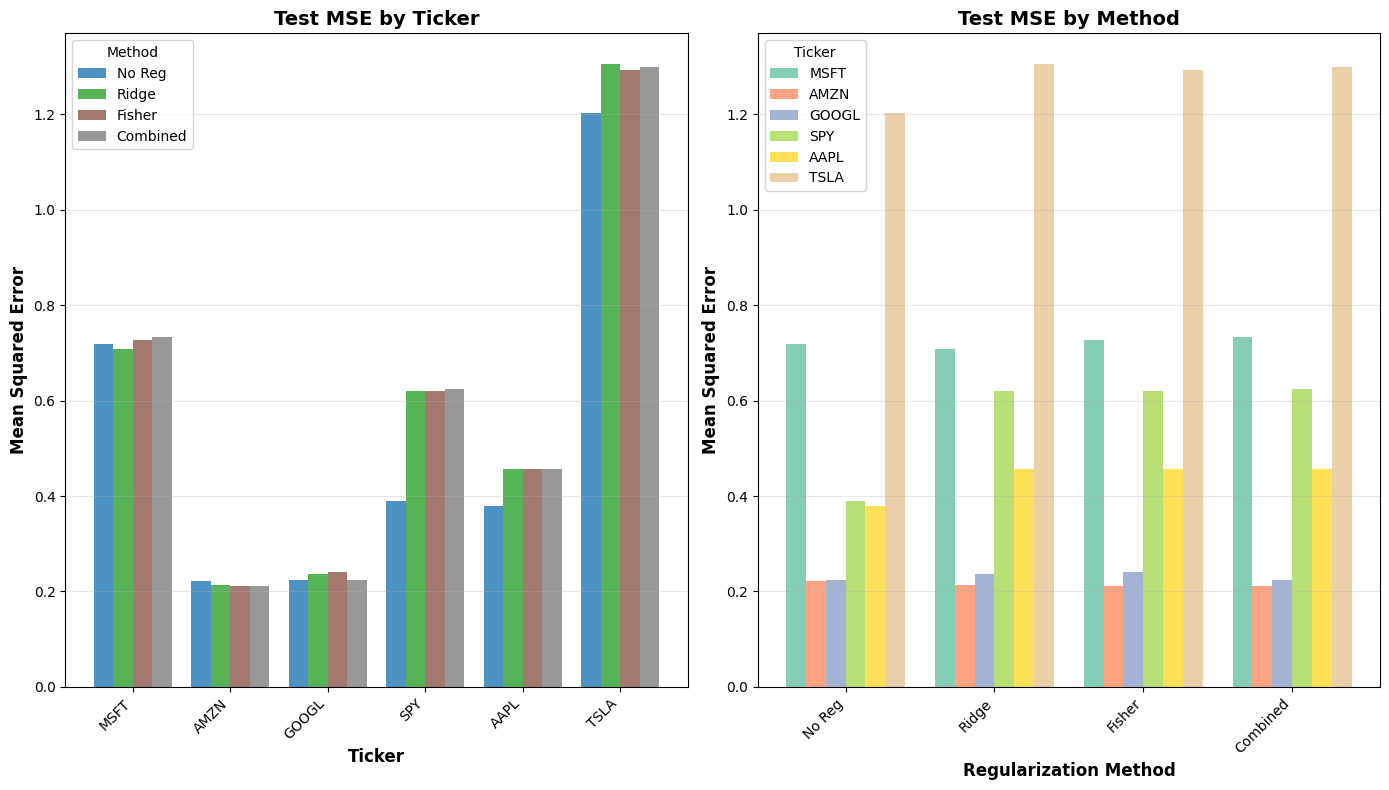

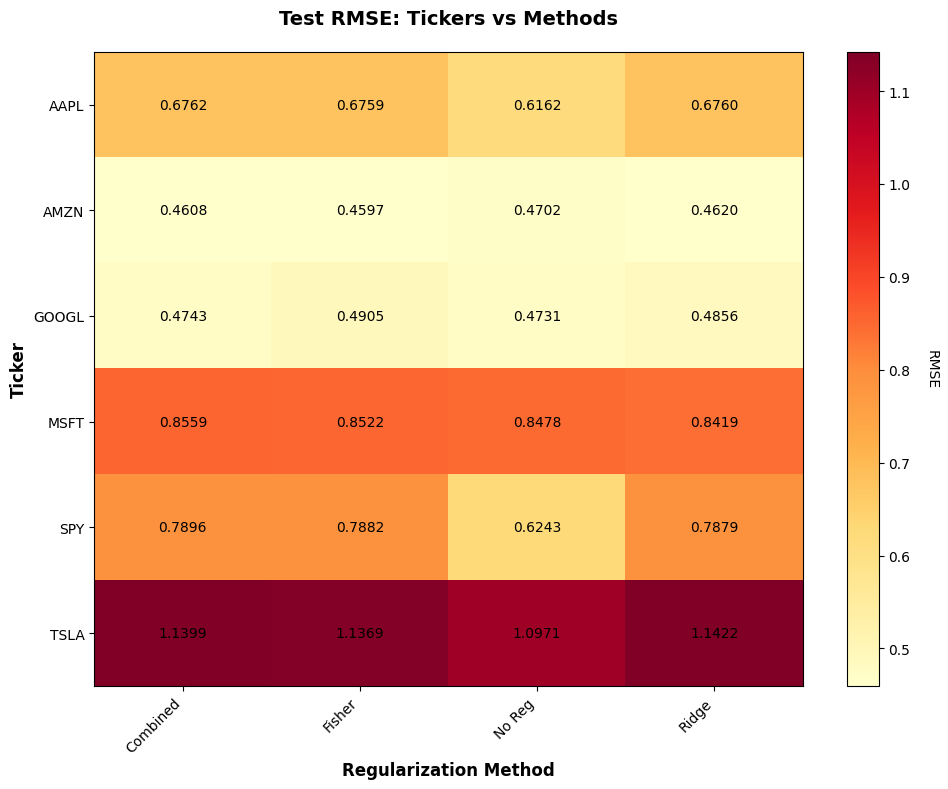

,Ticker,Config,MSE,RMSE
0,MSFT,No Reg,0.718779,0.847808
1,MSFT,Ridge,0.708848,0.841931
2,MSFT,Fisher,0.726195,0.852171
3,MSFT,Combined,0.732631,0.855939
4,AMZN,No Reg,0.221135,0.470250
5,AMZN,Ridge,0.213471,0.462030
6,AMZN,Fisher,0.211332,0.459708
7,AMZN,Combined,0.212354,0.460819
8,GOOGL,No Reg,0.223824,0.473100
9,GOOGL,Ridge,0.235819,0.485612


Config,Combined,Fisher,No Reg,Ridge
Ticker,,,,
AAPL,0.676215,0.675947,0.616196,0.675999
AMZN,0.460819,0.459708,0.470250,0.462030
GOOGL,0.474252,0.490532,0.473100,0.485612
MSFT,0.855939,0.852171,0.847808,0.841931
SPY,0.789616,0.788185,0.624266,0.787947
TSLA,1.139893,1.136886,1.097108,1.142247


In [15]:
# Plot MSE comparison
mse_df = plot_ticker_mse_comparison(calibrated_models, testing_data)

# Plot RMSE heatmap
rmse_pivot = plot_ticker_mse_heatmap(calibrated_models, testing_data, metric='RMSE')

# Display the data
display(mse_df)
display(rmse_pivot)